In [1]:
import os, sys
sys.path.append("../..")

import attr
import math
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

In [2]:
tf.config.set_visible_devices([], 'GPU') 

In [3]:
from filterflow.base import State
from filterflow.resampling.standard import SystematicResampler, StratifiedResampler, MultinomialResampler
from filterflow.resampling.base import NoResampling
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform, PartiallyCorrectedRegularizedTransform
from filterflow.resampling.differentiable.sliced import SVDSlicedTransform
from filterflow.resampling.differentiable.optimized import OptimizedPointCloud
from filterflow.resampling.differentiable.optimizer.sgd import SGD
from filterflow.resampling.differentiable.ricatti.solver import PetkovSolver
from filterflow.resampling.differentiable.loss.sliced_wasserstein.swd import SlicedWassersteinDistance
from filterflow.resampling.differentiable.loss.regularized import SinkhornLoss
from filterflow.resampling.differentiable.loss.sliced_wasserstein.utils import sqeuclidean, norm_1

This notebook aims to demonstrate the differentiability issue encountered at resampling time. To do this we will compare functionals of the point cloud whilst changing a parameter.

In [4]:
tf.random.set_seed(222)

B = 1
N = 25
D = 1

x = tf.random.normal([B, N, D], 0., 1.)
y = tf.zeros(D)

log_weights = tf.zeros([B, N]) - math.log(N)
flags = tf.constant([True])



In [5]:
def log_likelihood(state, observation, resampler):
    rv = tfp.distributions.MultivariateNormalDiag(tf.zeros(D), tf.ones(D))
    log_prob = rv.log_prob(observation-state.particles)
    log_weights = log_prob - tf.reduce_logsumexp(log_prob, 1, keepdims=True)
    state = attr.evolve(state, log_weights=log_weights, weights=tf.math.exp(log_weights))
    state = resampler.apply(state, flags)
    log_prob = rv.log_prob(observation-state.particles) + state.log_weights
    return tf.reduce_logsumexp(log_prob)
    

In [6]:
n_data = 150
linspace = np.linspace(-0.5, 0.5, n_data).astype(np.float32)
linspace_dataset = tf.data.Dataset.from_tensor_slices(linspace)

In [7]:
@tf.function
def get_data_no_reset_seed(linspace, resampler, x, y):
    res = tf.TensorArray(dtype=tf.float32, dynamic_size=False, size=n_data)
    grads = tf.TensorArray(dtype=tf.float32, dynamic_size=False, size=n_data)
    i = tf.constant(0, dtype=tf.int64)
    s = tf.constant(0., dtype=tf.float64)
    total_tic = tf.timestamp()
    for i, z_val in linspace_dataset.enumerate():
        tic = tf.timestamp()
        with tf.GradientTape() as tape:
            tape.watch(z_val)
            z = z_val + tf.zeros(D)
            state = State(x + z, log_weights, tf.math.exp(log_weights), tf.constant([0.]), None, None)
            ll = log_likelihood(state, y, resampler)
        ll_grad = tape.gradient(ll, z_val)
        j = tf.cast(i, tf.int32)
        res = res.write(j, ll)

        grads = grads.write(j, ll_grad)
        toc = tf.timestamp()
        s = s + (toc - tic)
        tf.print('Step', i+1, '/', n_data, ', seconds/iter =', s / tf.cast(i+1, tf.float64), end='\r')
    total_toc = tf.timestamp()

    tf.print('Step', i+1, '/', n_data, ', total time (seconds) =', total_toc - total_tic)
    return res.stack(), grads.stack()

# do not decorate this. seed is being set
def get_data(linspace, resampler, x, y, seed):
    res = []
    grads = []
    for z_val in tqdm.tqdm(linspace):
        z_ = tf.constant(z_val)
        tf.random.set_seed(seed)
        with tf.GradientTape() as tape:
            tape.watch(z_)
            z = z_ + tf.zeros(D)
            state = State(x + z, log_weights, tf.math.exp(log_weights), tf.constant([0.]), None, None)
            ll = log_likelihood(state, y, resampler)
        ll_grad = tape.gradient(ll, z)
        res.append(ll.numpy().sum())
        grads.append(ll_grad.numpy().sum())
        
    return res, grads
        

In [8]:
systematic = SystematicResampler()
multinomial = MultinomialResampler()
stratified = StratifiedResampler()
no_resampling = NoResampling()

epsilon = tf.constant(0.25)
scaling = tf.constant(0.75)
convergence_threshold = tf.constant(1e1)
max_iter = tf.constant(500)

regularized = RegularisedTransform(epsilon, scaling, max_iter, convergence_threshold)

partially_corrected = PartiallyCorrectedRegularizedTransform(regularized)

svd_sliced_resampler = SVDSlicedTransform(1)
partially_corrected_svd = PartiallyCorrectedRegularizedTransform(svd_sliced_resampler)

solver = PetkovSolver(n_iter=tf.constant(50))
corrected_no_grad = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=False)
corrected = CorrectedRegularizedTransform(epsilon, scaling, max_iter, convergence_threshold, ricatti_solver=solver, propagate_correction_gradient=True)

sinkhorn_loss = SinkhornLoss(epsilon, symmetric=True, scaling=scaling, max_iter=tf.constant(100), convergence_threshold=convergence_threshold)
sinkhorn_optimizer = SGD(sinkhorn_loss, 1., 50, 0.9)
sinkhorn_optimized_cloud = OptimizedPointCloud(sinkhorn_optimizer, regularized)

sliced_loss = SlicedWassersteinDistance(tf.constant(5), norm_1)
sliced_optimizer = SGD(sliced_loss, 1., tf.constant(25), 0.9)
sliced_optimized_cloud = OptimizedPointCloud(sliced_optimizer, systematic)

In [9]:

weights = tf.random.uniform([B, N], 0., 1.)**2
weights = weights / tf.reduce_sum(weights, -1)


state = State(x, tf.math.log(weights), weights, tf.constant([0.]), None, None)
svd_state = svd_sliced_resampler.apply(state, flags=flags)
multinomial_state = multinomial.apply(state, flags=flags)

In [10]:
import ot
np_x = x.numpy().squeeze()
np_w = weights.numpy().squeeze()
np_uniform = np.ones(N)/N

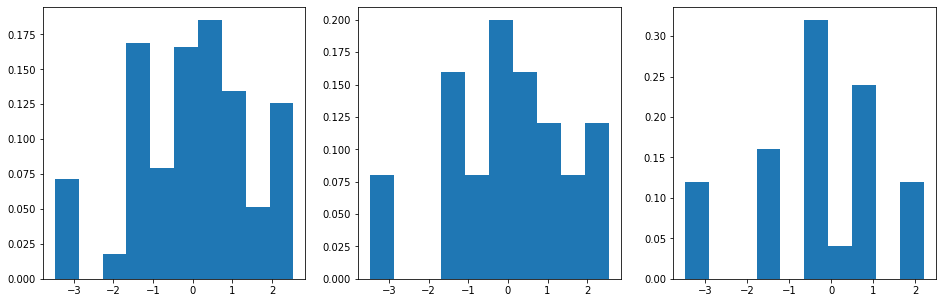

In [11]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 5))
axes[0].hist(state.particles.numpy().squeeze(), bins=10, weights=state.weights.numpy().squeeze())
axes[1].hist(svd_state.particles.numpy().squeeze(), bins=10, weights=svd_state.weights.numpy().squeeze())
_ = axes[2].hist(multinomial_state.particles.numpy().squeeze(), bins=10, weights=multinomial_state.weights.numpy().squeeze())

In [ ]:
no_resampling_data, no_resampling_grad = get_data_no_reset_seed(linspace, no_resampling, x, y)
# systematic_data, systematic_grad = get_data(linspace, systematic, x, y, 42)
multinomial_data, multinomial_grad = get_data(linspace, multinomial, x, y, 51)
# stratified_data, stratified_grad = get_data(linspace, stratified, x, y, 44)

regularized_data, regularized_grad = get_data_no_reset_seed(linspace, regularized, x, y)
# corrected_no_grad_data, corrected_no_grad_grad = get_data_no_reset_seed(linspace, corrected_no_grad, x, y)
# corrected_data, corrected_grad = get_data_no_reset_seed(linspace, corrected, x, y)
svd_data, svd_grad = get_data_no_reset_seed(linspace, svd_sliced_resampler, x, y)
partially_corrected_svd_data, partially_corrected_svd_grad = get_data_no_reset_seed(linspace, partially_corrected_svd, x, y)
# partially_corrected_data, partially_corrected_grad = get_data_no_reset_seed(linspace, partially_corrected, x, y)
# sliced_optimized_data, sliced_optimized_grad = get_data_no_reset_seed(linspace, sliced_optimized_cloud, x, y)
# sinkhorn_optimized_data, sinkhorn_optimized_grad = get_data_no_reset_seed(linspace, sinkhorn_optimized_cloud, x, y)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Step 150 / 150 , total time (seconds) = 0.28258204460144043


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 29.73it/s]


Step 150 / 150 , total time (seconds) = 0.86134600639343262
[[[[0 0 0 ... 0 0 0]]]]
[[[0 0 0 ... 0 0 0]]]
[[[[0.3535676 0.207181513 0.753882945 ... 0.854741812 1.06409085 1.05581212]]]]
[[[0.3535676 0.207181513 0.753882945 ... 0.854741812 1.06409085 1.05581212]]]
[[[[[-0.0158219673]
   [0.00169203512]
   [-0.0349325649]
   ...
   [-0.0353076272]
   [-0.0202753376]
   [0.0183384269]]]]]
[[[[-0.0158219673]
   [0.00169203512]
   [-0.0349325649]
   ...
   [-0.0353076272]
   [-0.0202753376]
   [0.0183384269]]]]
[[[[0 0 0 ... 0 0 0]]]]iter = 0.058561086654663086
[[[0 0 0 ... 0 0 0]]]
[[[[0.35245955 -0.0944582224 0.752322 ... 0.853410482 1.06331599 1.07208252]]]]
[[[0.35245955 -0.0944582224 0.752322 ... 0.853410482 1.06331599 1.07208252]]]
[[[[[-0.0155612091]
   [0.00170479377]
   [-0.0347834192]
   ...
   [-0.0352927968]
   [-0.0208541118]
   [0.0184084289]]]]]
[[[[-0.0155612091]
   [0.00170479377]
   [-0.0347834192]
   ...
   [-0.0352927968]
   [-0.0208541118]
   [0.0184084289]]]]
[[[[0 0 0

In [ ]:
plt.plot(linspace, svd_data, label='svd_data')
plt.plot(linspace, partially_corrected_svd_data, label='partially_corrected_svd_data')
plt.plot(linspace, regularized_data, label='regularized_data')
plt.legend()

In [ ]:
plt.plot(linspace, svd_grad, label='svd_data')
plt.step(linspace, partially_corrected_svd_grad, label='partially_corrected_svd_data')
plt.step(linspace, regularized_grad, label='regularized_data')
plt.legend()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=True)
axes[0].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[1].plot(linspace, no_resampling_data, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_data, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_data, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_data, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_data, label='regularized')
axes[1].plot(linspace, corrected_data, label='corrected')
axes[1].plot(linspace, corrected_no_grad_data, label='corrected_no_grad')
axes[1].plot(linspace, partially_corrected_data, label='partially_corrected_data')
axes[1].plot(linspace, partially_corrected_svd_data, label='partially_corrected_svd_data')
axes[1].plot(linspace, svd_data, label='svd_data')
axes[1].plot(linspace, sliced_optimized_data, label='sliced_optimized')
axes[1].plot(linspace, sinkhorn_optimized_data, label='sinkhorn_optimized')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_likelihood.png'))

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharex=True, sharey=False)
axes[0].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[1].step(linspace, no_resampling_grad, label='no resampling', linestyle='--', color='k')
axes[0].step(linspace, systematic_grad, label='systematic', alpha=0.75)
axes[0].step(linspace, multinomial_grad, label='multinomial', alpha=0.75)
axes[0].step(linspace, stratified_grad, label='stratified', alpha=0.75)
axes[1].plot(linspace, regularized_grad, label='regularized')
axes[1].plot(linspace, corrected_grad, label='corrected')
axes[1].plot(linspace, corrected_no_grad_grad, label='corrected_no_grad')
axes[1].plot(linspace, partially_corrected_grad, label='partially_corrected_data')
axes[1].plot(linspace, sliced_optimized_data, label='sliced_optimized')
axes[1].step(linspace, svd_grad, label='svd_data')
axes[1].step(linspace, partially_corrected_svd_grad, label='partially_corrected_svd_data')
# axes[1].plot(linspace, sliced_optimized_data, label='sliced_optimized')
axes[1].plot(linspace, sinkhorn_optimized_grad, label='sinkhorn_optimized')
_ = axes[0].legend(), axes[1].legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration_gradient.png'))

In [ ]:
import tensorflow as tf
a = tf.squeeze(x)
with tf.GradientTape() as tape:
    tape.watch(a)
    b, idx = tf.math.top_k(a, k=N)
tape.gradient(b[...], a)

In [ ]:
tf.scatter_nd(idx, [1.], a.shape)

In [ ]:
tf.scatter_nd?

In [ ]:
tf.math.top_k(a, k=N)